In [1]:
%matplotlib notebook
import flux

Missing flux value for: GLEAM J202818-254302 at frequency: 204 MHz.
Missing flux value for: GLEAM J202818-254302 at frequency: 212 MHz.
Missing flux value for: GLEAM J202818-254302 at frequency: 220 MHz.
Missing flux value for: GLEAM J202818-254302 at frequency: 227 MHz.
Missing spectral index for: GLEAM J202818-254302


//anaconda3/envs/hera/lib/python3.7/site-packages/spin1_beam_model/jones_matrix_field.py:18: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.pos1_Elm_samples = h5f["pos1_Elm"].value
//anaconda3/envs/hera/lib/python3.7/site-packages/spin1_beam_model/jones_matrix_field.py:19: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.neg1_Elm_samples = h5f["neg1_Elm"].value
//anaconda3/envs/hera/lib/python3.7/site-packages/spin1_beam_model/jones_matrix_field.py:20: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.freq_nodes = h5f["frequencies"].value
//anaconda3/envs/hera/lib/python3.7/site-packages/spin1_beam_model/jones_matrix_field.py:21: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.L_model = h5f["spatial_bandlimit"].value
//anaconda3/envs/hera/lib/python3.7/site-packages/spin1_beam_model/jones_matrix_field.py:22: H5pyDeprec

delta_nu_in is 1000000.0


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp

In [3]:
arbitrary_source = flux.catalog.obj_catalog[999]
arb_ra = arbitrary_source.ra_angle
arb_dec = arbitrary_source.dec_angle
J = flux.stokes.J_matrix(arb_ra, arb_dec)
J.shape

(1, 2, 2)

In [4]:
arb_ra = flux.rot.get_lst()
arb_dec = np.radians(flux.rot.hera_lat)
J = flux.stokes.J_matrix(arb_ra, arb_dec)
J

array([[[ 2.75164312e-05+3.20969906e-05j,
          8.12625503e-01-5.82786230e-01j],
        [ 8.12625503e-01-5.82786230e-01j,
         -2.75164278e-05-3.20969861e-05j]]])

In [5]:
Am = flux.stokes.A_matrix(arb_ra, arb_dec)
print(Am)
Am.shape

[[[ 2.23592066e-06+4.21190303e-05j  5.00022176e-01-5.00019940e-01j
    4.99980057e-01+4.99977821e-01j  1.77901197e-09-3.05343180e-15j]]

 [[ 4.99980057e-01+4.99977821e-01j -3.84110468e-15-6.43217762e-16j
    4.21172153e-05-2.23592010e-06j -4.99977821e-01+4.99980057e-01j]]

 [[ 5.00022176e-01-5.00019940e-01j -4.21207733e-05+2.23592010e-06j
    2.32276085e-15+7.00217150e-16j -5.00019940e-01-5.00022176e-01j]]

 [[ 1.77901063e-09+3.11043373e-15j -5.00019940e-01-5.00022176e-01j
   -4.99977821e-01+4.99980057e-01j -2.23592066e-06-4.21190303e-05j]]]


(4, 1, 4)

In [6]:
Am[0][0][0]

(2.2359206598448397e-06+4.2119030322054276e-05j)

In [7]:
#nside = 128
#hp.mollview(np.real(Am[:, 0, 0]), rot=[0, 90], title='xy? real')

In [8]:
# Display available antennae
print(flux.demo.active_ants)

[0, 1, 2, 11, 12, 13, 14, 23, 24, 25, 26, 27, 36, 37, 38, 39, 40, 41, 50, 51, 52, 53, 54, 55, 65, 66, 67, 68, 69, 70, 71, 82, 83, 84, 85, 86, 87, 88, 98, 120, 121, 122, 123, 124, 136, 137, 138, 139, 140, 141, 142, 143]


In [9]:
# we sample three sources almost at random, and 2/3 are zero

print(arbitrary_source)
print(flux.vis.visibility(2, 11, arbitrary_source))

print(flux.vis.visibility(36, 37, flux.catalog.obj_catalog[981]))
print(flux.vis.visibility(88, 121, flux.catalog.obj_catalog[134]))
# also, would we not expect the first term to dominate? And yet it is not even the largest
    # of numbers all with magnitudes less than one

Name: GLEAM J185915-381842
Right ascension: 284.8155
Declination: -37.688250000000004
151 MHz flux: 1.2316479999999999

[4.53234042e-04-0.00030851j 1.74416015e-04-0.00053188j
 2.07462470e-04-0.00131243j 9.39366181e-05-0.00047981j]
[-6.71364807e-04-0.00041625j -6.44820652e-05+0.00163676j
  1.71240801e-03-0.00182754j  1.86434946e-04+0.00034846j]
[0.+0.j 0.+0.j 0.+0.j 0.+0.j]


In [ ]:
"""
This section kills the kernel! Do NOT run it!!
I am leaving it here as a to-do of sorts. I think, that my inability
to run it in this environment may be a bad sign.
(It does work fine in the shell, so far as I can tell.)

t = 0
arg = 134

obj = flux.catalog.obj_catalog[arg]
ra = np.radians(obj.ra_angle)
dec = np.radians(obj.dec_angle)
while t < 2 * np.pi:
    print(t)
    t += np.pi / 72
    
    print(flux.stokes.J_matrix(ra, dec, t))
    print("\n")

"""

In [12]:
vist = flux.vis.source_over_time(
    88, 121, arbitrary_source, 0, 2/3 * np.pi, np.pi / 72
)
vist

array([[-4.78339478e-04-2.72280969e-04j, -5.66781990e-04+5.34969626e-05j,
        -1.26108874e-03+3.71862092e-04j, -4.63916709e-04+1.16175506e-04j],
       [-5.29098928e-04-1.51657754e-04j, -5.38133007e-04+1.85789191e-04j,
        -1.13765205e-03+6.59067712e-04j, -4.23375975e-04+2.22412297e-04j],
       [-5.41825317e-04+9.68051433e-05j, -4.01355732e-04+4.03756482e-04j,
        -7.31236723e-04+1.09266265e-03j, -2.82193964e-04+3.86108848e-04j],
       [-3.63465364e-04+4.13326755e-04j, -6.23392262e-05+5.65880331e-04j,
         1.08905014e-04+1.31024987e-03j,  1.98676637e-05+4.77826052e-04j],
       [ 9.14217725e-05+5.42760085e-04j,  3.99748815e-04+4.05351534e-04j,
         1.08534322e-03+7.42048955e-04j,  3.83284226e-04+2.86012925e-04j],
       [ 5.25500522e-04+1.63694290e-04j,  5.42241354e-04-1.73448297e-04j,
         1.15239508e-03-6.32920464e-04j,  4.28338750e-04-2.12685407e-04j],
       [ 2.91967305e-04-4.66585360e-04j, -2.98278527e-05-5.68525656e-04j,
        -3.19003956e-04-1.275474

<IPython.core.display.Javascript object>


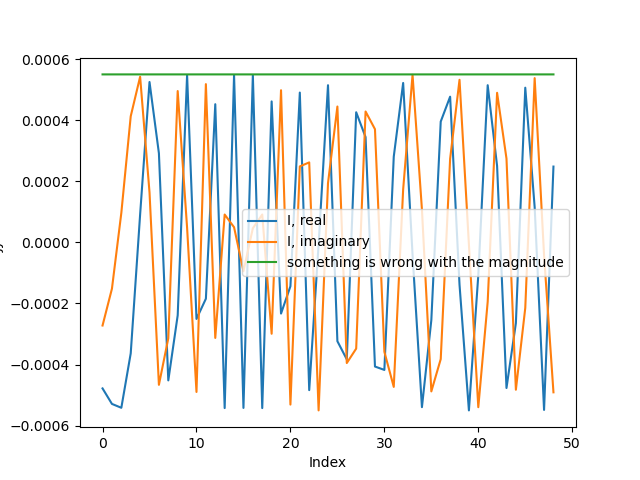

In [27]:
plt.plot(np.real(vist[:, 0]), label="I, real")
plt.plot(np.imag(vist[:, 0]), label="I, imaginary")
plt.plot(np.abs(vist[:, 0]), label="something is wrong with the magnitude")

plt.xlabel("Index")
plt.ylabel("Jy?")

plt.legend()

plt.show()

<IPython.core.display.Javascript object>


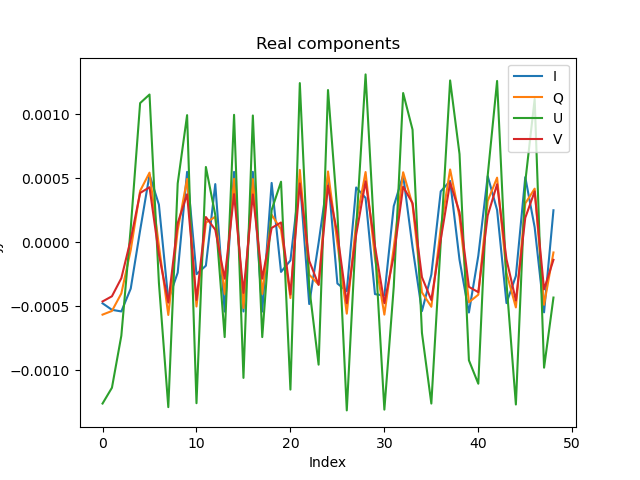

In [24]:
plt.plot(np.real(vist[:, 0]), label="I")
plt.plot(np.real(vist[:, 1]), label="Q")
plt.plot(np.real(vist[:, 2]), label="U")
plt.plot(np.real(vist[:, 3]), label="V")

plt.xlabel("Index")
plt.ylabel("Jy?")
plt.title("Real components")

plt.legend()

plt.show()

<IPython.core.display.Javascript object>


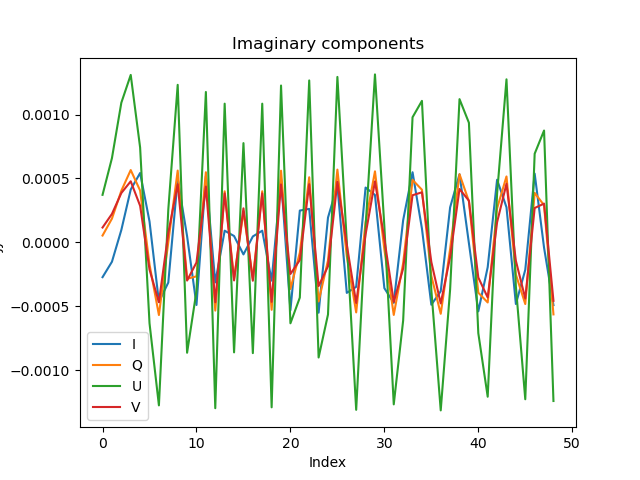

In [25]:
plt.plot(np.imag(vist[:, 0]), label="I")
plt.plot(np.imag(vist[:, 1]), label="Q")
plt.plot(np.imag(vist[:, 2]), label="U")
plt.plot(np.imag(vist[:, 3]), label="V")

plt.xlabel("Index")
plt.ylabel("Jy?")
plt.title("Imaginary components")

plt.legend()

plt.show()